In [1]:
%load_ext autoreload
%autoreload 2
%run prerun.py
%matplotlib inline

device = torch.device('cuda:1')

SOLVERS:  ['dopri5', 'bdf', 'rk4', 'midpoint', 'adams', 'explicit_adams', 'fixed_adams']
{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


## Data

In [3]:
sys.path.append('../')
from model import YModel, OptLoss
from utils import generate_data
y_sampler = YModel()
mu_range = (-10, 10)
n_samples = 10000
x, conditions = generate_data(y_sampler, device, n_samples=n_samples, mu_range=mu_range, mu_dim=2)

print(x.shape, conditions.shape)

torch.Size([10000, 1]) torch.Size([10000, 3])


## Define model

In [7]:
regularization_fns = None
# regularization_fns, regularization_coeffs = create_regularization_fns()

model = build_model_tabular(dims=1, 
                            condition_dim=3,
                            layer_type='concat_v2',
                            num_blocks=3,
                            rademacher=False,
                            nonlinearity='tanh',
                            solver='dopri5',
                            hidden_dims=(128, 128),
                            bn_lag=0.01, 
                            batch_norm=True,
                            regularization_fns=regularization_fns).to(device)
sum(p.numel() for p in model.parameters()  if p.requires_grad)

78068

In [8]:
import torch.utils.data as pytorch_data_utils
BATCH_SIZE = 1024
dataset = torch.utils.data.TensorDataset(x, conditions)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training

iter 77: loss = 2.360 5e-05


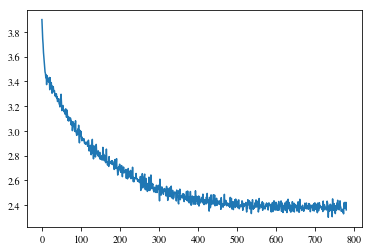

KeyboardInterrupt: 

In [10]:
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(model.parameters()) 
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

B = 5000
for epoch in tqdm(range(1000)):
    for x_batch, cond_batch in tqdm(dataloader):
        x_batch = x_batch.to(device)
        cond_batch = cond_batch.to(device)

        loss = compute_loss(model, data=x_batch, condition=cond_batch)

        if loss != loss:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    clear_output()
    print('iter %s:' % epoch, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
    plt.figure()
    plt.plot(losses)
    # plt.ylim(1.1, 3)
    plt.show()

## Evalutation

In [150]:
model.eval();
model.cpu();
sample_fn, density_fn = get_transforms(model)

In [151]:
mu = dist.Uniform(*mu_range_test).sample([mu_samples, 2]) # .to(device)
mu.requires_grad=True
mu_r = mu.repeat(1, batch_size).view(-1, 2)
x_r = y_sampler.x_dist.sample(torch.Size([len(mu) * batch_size , 1])) # .to(device)

In [152]:
mu_range_test = (-20, 20)
batch_size = 100
mu_samples = 5000


samples = sample_fn(torch.randn(mu_samples * batch_size, 1).float(), torch.cat([mu_r, x_r],dim=1))
rs = OptLoss.SigmoidLoss(samples, 5, 10).reshape(-1, batch_size).mean(dim=1)

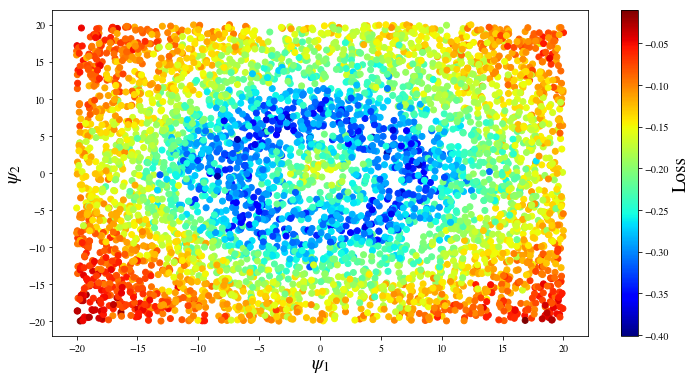

In [153]:
plt.figure(figsize=(12, 6))

plt.scatter(mu[:, 0].cpu().detach().numpy(), mu[:,1].cpu().detach().numpy(), c=rs.cpu().detach().numpy(),  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

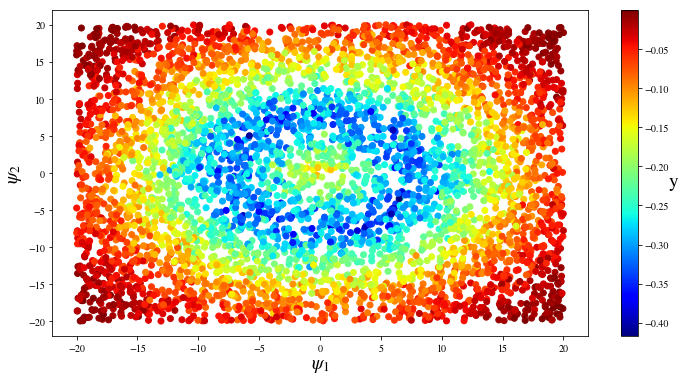

In [154]:
y_sampler.make_condition_sample({'mu': mu_r, 'X': x_r})

y = y_sampler.condition_sample()
c = OptLoss.SigmoidLoss(y, 5, 10).reshape(-1, batch_size).mean(dim=1)

plt.figure(figsize=(12, 6))
plt.scatter(mu[:,0].cpu().detach().numpy(), mu[:, 1].cpu().detach().numpy(), c=c.cpu().detach().numpy(), cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('y', rotation=360, fontsize=19)
plt.show()

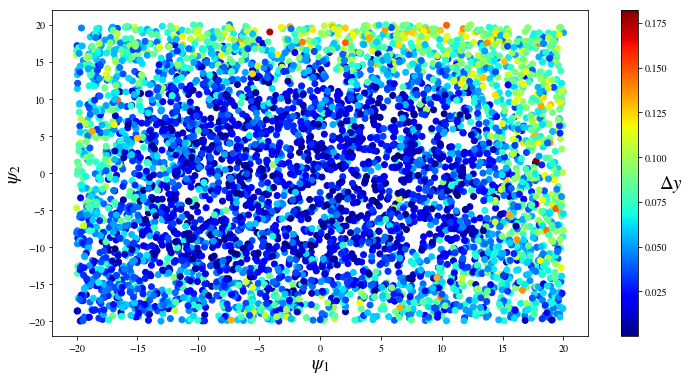

In [155]:
plt.figure(figsize=(12, 6))
plt.scatter(mu[:,0].cpu().detach().numpy(), mu[:, 1].cpu().detach().numpy(), c=np.abs((c - rs).detach().cpu().numpy()), cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label(f'$\Delta y$', rotation=360, fontsize=19)
plt.show()

In [156]:
%%time
rs.sum().backward(retain_graph=True)

CPU times: user 8min 51s, sys: 15min 8s, total: 23min 59s
Wall time: 2min 55s


In [157]:
grad_model = mu.grad.clone()

In [158]:
mu.grad.zero_()

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [159]:
c.sum().backward()

In [160]:
grad_true = mu.grad.clone()

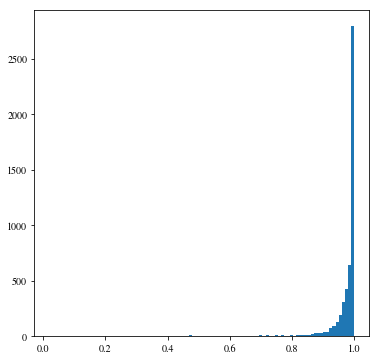

In [182]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_distance_grad = np.abs(np.diag(cosine_similarity(grad_true.cpu().detach().numpy(), grad_model.cpu().detach().numpy())))
plt.hist(cosine_distance_grad, bins=100);

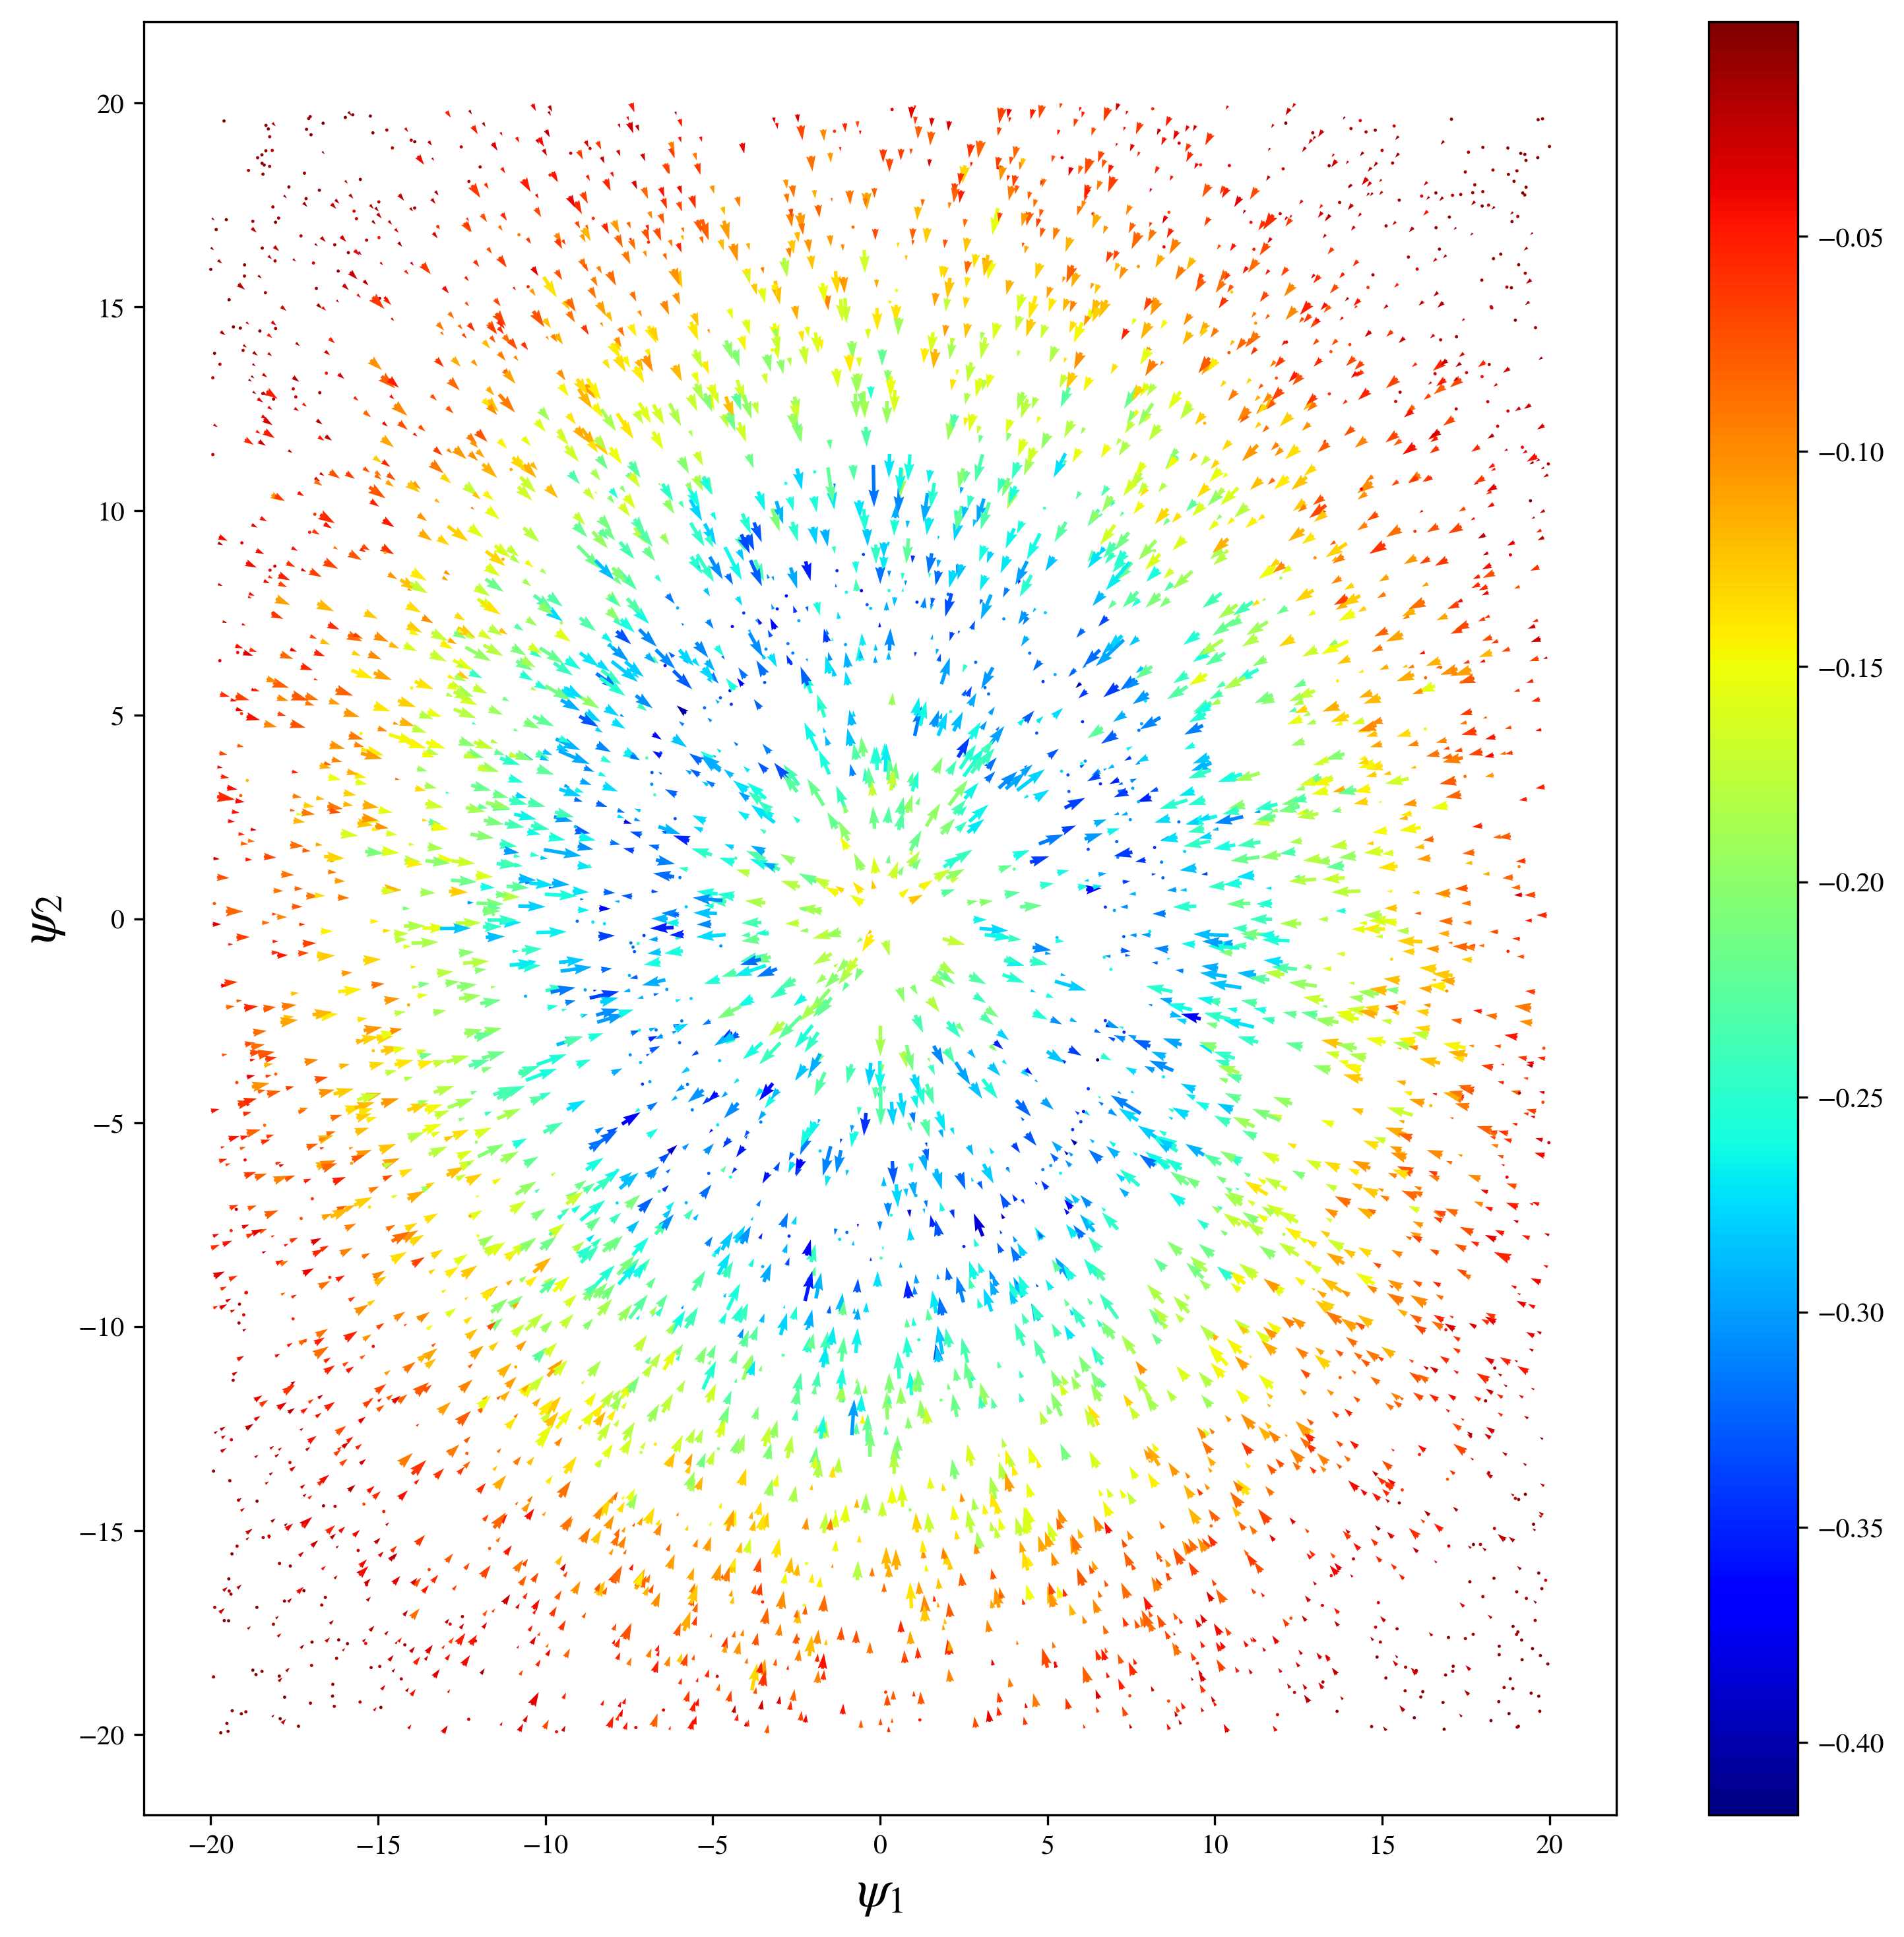

In [187]:
plt.figure(figsize=(12, 12), dpi=300)

plt.quiver(mu[:, 0].cpu().detach().numpy(), 
           mu[:,1].cpu().detach().numpy(), 
           -grad_true[:, 0].cpu().detach().numpy(), 
           -grad_true[:, 1].cpu().detach().numpy(),
           c.cpu().detach().numpy(),
           cmap=my_cmap)
plt.colorbar();
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

Text(0, 0.5, '$\\psi_2$')

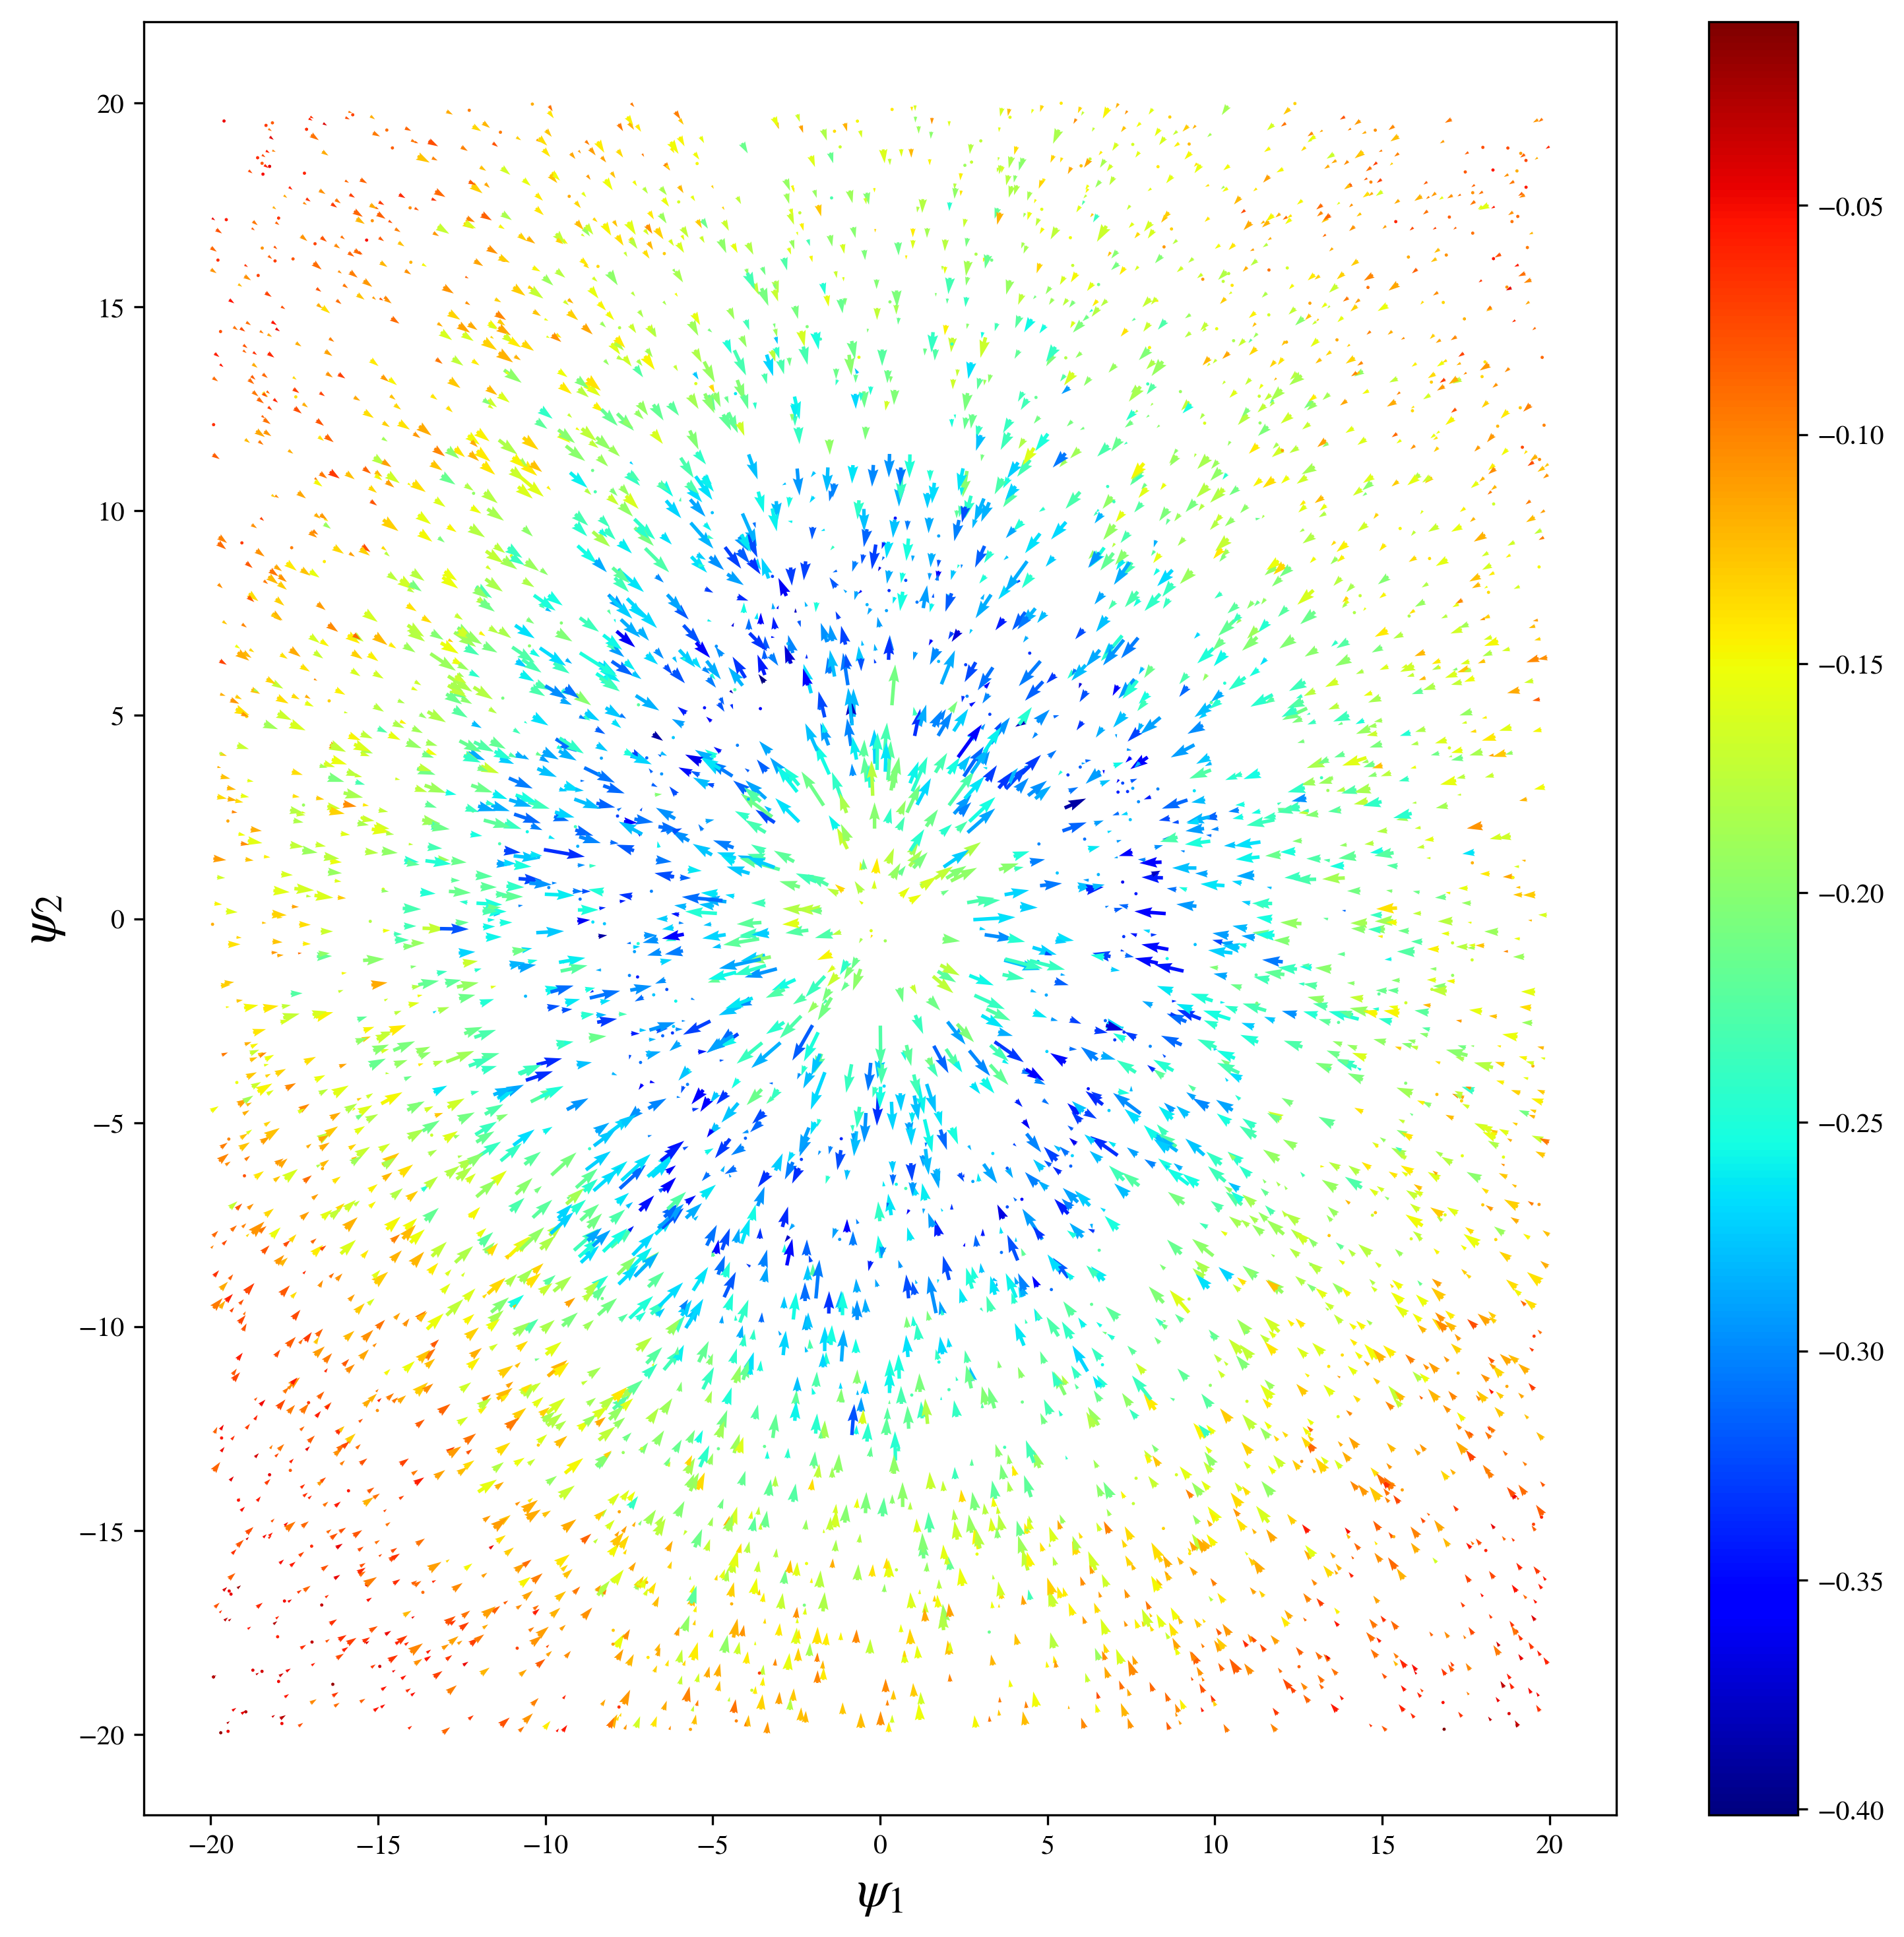

In [188]:
plt.figure(figsize=(12, 12), dpi=300)

plt.quiver(mu[:, 0].cpu().detach().numpy(), 
           mu[:,1].cpu().detach().numpy(), 
           -grad_model[:, 0].cpu().detach().numpy(), 
           -grad_model[:, 1].cpu().detach().numpy(),
           rs.cpu().detach().numpy(),
           cmap=my_cmap)
plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)

In [193]:
log_density = density_fn(y, torch.cat([mu_r, x_r],dim=1))

In [200]:
log_density = log_density.reshape(-1, batch_size)

In [214]:
probs = np.exp(log_density.cpu().detach().numpy()) / np.sum(np.exp(log_density.cpu().detach().numpy()), axis=1, keepdims=True)

In [220]:
log_density

tensor([139.0100, 102.1349, -11.6957,  ...,  58.0277,   4.5155,  -0.3336],
       grad_fn=<SumBackward2>)

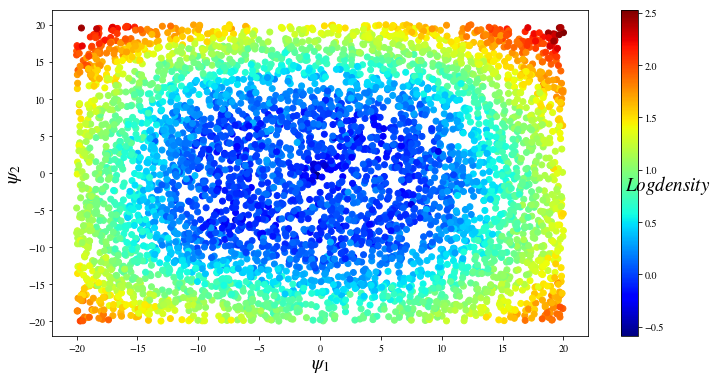

In [225]:
plt.figure(figsize=(12, 6))
plt.scatter(mu[:,0].cpu().detach().numpy(), mu[:, 1].cpu().detach().numpy(), 
            c=log_density.mean(dim=1).detach().cpu().numpy(), cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label(f'$Log density$', rotation=360, fontsize=19)
plt.show()